## Importing Libraries

In [1]:
from pathlib import Path
import requests
import pickle
import gzip
from matplotlib import pyplot as plt
import tqdm

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

## Device

In [2]:
# Device setup
device = (
    "cuda:0" if torch.cuda.is_available() else # Nvidia GPU
    "mps" if torch.backends.mps.is_available() else # Apple Silicon GPU
    "cpu"
)
print(f"Device = {device}")

Device = cuda:0


## Hyperparameters

In [3]:
learning_rate = 0.1
batch_size = 64
val_batch_size = 1000
epochs = 5
validation_size = 0.1

## Dataset

In [4]:
# Dataset path
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"
PATH.mkdir(parents=True, exist_ok=True)

In [5]:
# Dataset download
URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)
        
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")        

In [6]:
# Dataset shape
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

(50000, 784)
(50000,)
(10000, 784)
(10000,)


5


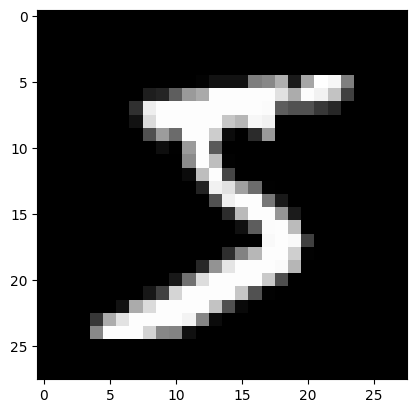

In [7]:
# Dataset sample
plt.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(y_train[0])

In [8]:
# Custom Dataset
class MNIST_Dataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        x = self.x[idx].reshape(1, 28, 28)
        y = self.y[idx]
        if self.transform:
            x = self.transform(x)
        return x, y
    
transfrom = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [9]:
# Full Dataset
train_ds = MNIST_Dataset(x_train, y_train, transform=transfrom)
test_ds = MNIST_Dataset(x_valid, y_valid, transform=transfrom)

train_size = int(len(train_ds) * (1 - validation_size))
valid_size = len(train_ds) - train_size
train_ds, valid_ds = random_split(train_ds, [train_size, valid_size])

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=val_batch_size, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=val_batch_size, shuffle=False)

In [10]:
# 2&3 Dataset
x_train_23 = x_train[(y_train == 2) | (y_train == 3)]
y_train_23 = y_train[(y_train == 2) | (y_train == 3)]
x_valid_23 = x_valid[(y_valid == 2) | (y_valid == 3)]
y_valid_23 = y_valid[(y_valid == 2) | (y_valid == 3)]

print(x_train_23.shape)
print(y_train_23.shape)
print(x_valid_23.shape)
print(y_valid_23.shape)

(10069, 784)
(10069,)
(2020, 784)
(2020,)


In [11]:
train_ds_23 = MNIST_Dataset(x_train_23, y_train_23, transform=transfrom)
test_ds_23 = MNIST_Dataset(x_valid_23, y_valid_23, transform=transfrom)

train_size_23 = int(len(train_ds_23) * (1 - validation_size))
valid_size_23 = len(train_ds_23) - train_size_23
train_ds_23, valid_ds_23 = random_split(train_ds_23, [train_size_23, valid_size_23])

train_dl_23 = DataLoader(train_ds_23, batch_size=batch_size, shuffle=True)
valid_dl_23 = DataLoader(valid_ds_23, batch_size=val_batch_size, shuffle=False)
test_dl_23 = DataLoader(test_ds_23, batch_size=val_batch_size, shuffle=False)

In [12]:
# DataLoader sample
xb, yb = next(iter(train_dl_23))
print(xb.shape, yb.shape)

torch.Size([64, 28, 1, 28]) torch.Size([64])


## Model

In [13]:
class MNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))
    
model_23 = MNIST_CNN().to(device)

In [14]:
# Model summary
print(model_23)

MNIST_CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(16, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
)


In [15]:
optimizer = optim.SGD(model_23.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

## Training

In [16]:
# Losses
train_losses = []
valid_losses = []

In [17]:
def train(model, train_dl, valid_dl, optimizer, criterion, epochs):
    for epoch in range(epochs):
        model.train()
        with tqdm.tqdm(train_dl, unit="batch") as tepoch:
            for xb, yb in tepoch:
                xb, yb = xb.to(device), yb.to(device)
                output = model(xb)
                loss = criterion(output, yb)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())
                tepoch.set_postfix(train_loss=loss.item())
        
        model.eval()
        with torch.no_grad():
            for xb, yb in valid_dl:
                xb, yb = xb.to(device), yb.to(device)
                output = model(xb)
                loss = criterion(output, yb)
                valid_losses.append(loss.item())
        
        print(f"Epoch {epoch + 1}, Train Loss: {sum(train_losses) / len(train_losses):.4f}, Validation Loss: {sum(valid_losses) / len(valid_losses):.4f}")

In [18]:
train(model_23, train_dl_23, valid_dl_23, optimizer, criterion, epochs)

100%|██████████| 142/142 [00:00<00:00, 214.74batch/s, train_loss=0.327]


Epoch 1, Train Loss: 0.6308, Validation Loss: 0.4254


100%|██████████| 142/142 [00:00<00:00, 284.73batch/s, train_loss=0.483]


Epoch 2, Train Loss: 0.5325, Validation Loss: 0.4024


100%|██████████| 142/142 [00:00<00:00, 282.04batch/s, train_loss=0.533]


Epoch 3, Train Loss: 0.4796, Validation Loss: 0.3850


100%|██████████| 142/142 [00:00<00:00, 284.42batch/s, train_loss=0.34] 


Epoch 4, Train Loss: 0.4419, Validation Loss: 0.3519


100%|██████████| 142/142 [00:00<00:00, 283.41batch/s, train_loss=0.231]


Epoch 5, Train Loss: 0.4105, Validation Loss: 0.3339


In [19]:
# Save model
torch.save(model_23.state_dict(), "mnist_cnn_23.pth")

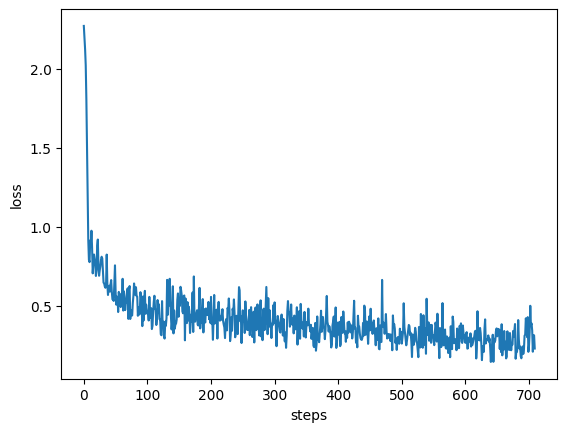

In [20]:
# Plot training losses
plt.plot(train_losses)
plt.xlabel("steps")
plt.ylabel("loss")
plt.show()

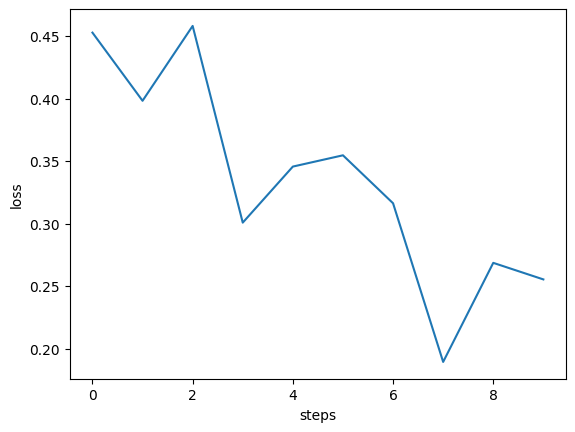

In [21]:
# Plot validation losses
plt.plot(valid_losses)
plt.xlabel("steps")
plt.ylabel("loss")
plt.show()

## Evaluation

In [22]:
def evaluate(model, test_dl):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in test_dl:
            xb, yb = xb.to(device), yb.to(device)
            output = model(xb)
            _, predicted = torch.max(output, 1)
            total += yb.size(0)
            correct += (predicted == yb).sum().item()
    return correct / total

In [23]:
print(f"Accuracy: {evaluate(model_23, test_dl_23):.4f}")

Accuracy: 0.9272


In [24]:
# Accuracy on each label
def evaluate_labels(model, test_dl):
    model.eval()
    correct = [0] * 10
    total = [0] * 10
    with torch.no_grad():
        for xb, yb in test_dl:
            xb, yb = xb.to(device), yb.to(device)
            output = model(xb)
            _, predicted = torch.max(output, 1)
            for i in range(len(yb)):
                label = yb[i]
                total[label] += 1
                if predicted[i] == label:
                    correct[label] += 1
    return [correct[i] / total[i] for i in range(10)]

Label 0, Accuracy: 0.0000
Label 1, Accuracy: 0.0000
Label 2, Accuracy: 0.9434
Label 3, Accuracy: 0.9117
Label 4, Accuracy: 0.0000
Label 5, Accuracy: 0.0000
Label 6, Accuracy: 0.0000
Label 7, Accuracy: 0.0000
Label 8, Accuracy: 0.0000
Label 9, Accuracy: 0.0000


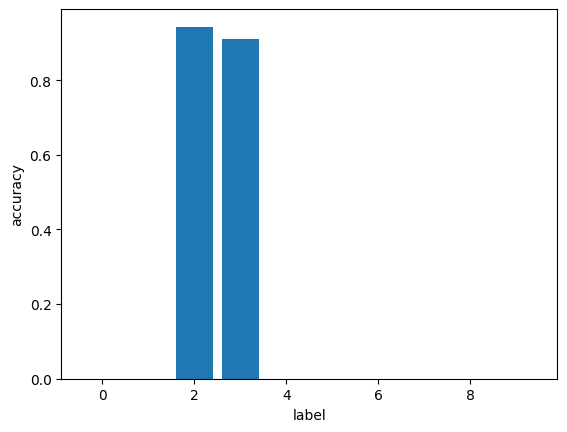

In [25]:
for i, acc in enumerate(evaluate_labels(model_23, test_dl)):
    print(f"Label {i}, Accuracy: {acc:.4f}")
    
plt.bar(range(10), evaluate_labels(model_23, test_dl))
plt.xlabel("label")
plt.ylabel("accuracy")
plt.show()